In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import pyxem as pxm
import sys
from skimage.feature import blob_dog, blob_log, blob_doh
from tqdm import tqdm
from scipy.spatial import distance, distance_matrix
from scipy.interpolate import interp2d
from scipy import ndimage
from scipy.signal import find_peaks, argrelextrema
import random as rd
from sklearn import decomposition
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
from skimage.exposure import rescale_intensity, adjust_gamma
from pyxem.signals.segments import LearningSegment
from hyperspy.signals import Signal2D

import matplotlib 
import copy
%matplotlib inline

c:\Users\a.santana\OneDrive - University of Florida\Desktop\Arman4Dstem\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def CustomCmap(from_rgb,to_rgb):            ###################### generate colormap

    # from color r,g,b
    r1,g1,b1 = from_rgb

    # to color r,g,b
    r2,g2,b2 = to_rgb

    cdict = {'red': ((0, r1, r1),
                   (1, r2, r2)),
           'green': ((0, g1, g1),
                    (1, g2, g2)),
           'blue': ((0, b1, b1),
                   (1, b2, b2))}

    cmap = LinearSegmentedColormap('custom_cmap', cdict)
    return cmap


cmaps= [                       ###################### generate colormap
    CustomCmap([0,0,0],[1,0,0]),
    CustomCmap([0,0,0],[0,1,0]),
    CustomCmap([0,0,0],[0,0,1]),
    CustomCmap([0,0,0],[1,1,0]),
    CustomCmap([0,0,0],[0,1,1]),
    CustomCmap([0,0,0],[1,0,1]),
    CustomCmap([0,0,0],[.5,0.2,1]),
    CustomCmap([0,0,0],[.2,0.5,1]),
    CustomCmap([0,0,0],[1,.2,.5]),
    CustomCmap([0,0,0],[.2,1,.5])
]
cmaps *= 50

n_col, n_row = 3, 3
def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap=plt.cm.gray):                 ###################### batch plot
    fig, axs = plt.subplots(
        nrows=n_row,
        ncols=n_col,
        figsize=(2.0 * n_col, 2.3 * n_row),
        facecolor="white",
        constrained_layout=True,
    )
    fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0)
    fig.set_edgecolor("black")
    fig.suptitle(title, size=16)
    for i, (ax, vec) in enumerate(zip(axs.flat, images)):
        vmax = max(vec.max(), -vec.min())
        im = ax.imshow(
            vec,
            cmap=cmaps[i],
            interpolation="nearest",
            vmin=0,
            vmax=vmax,
        )
        ax.axis("off")

    fig.colorbar(im, ax=axs, orientation="horizontal", shrink=0.99, aspect=40, pad=0.01)
    plt.show()
    
def subtract_background_dog(z, sigma_min, sigma_max):        ###################### background subtract for diffraction image
    blur_max = gaussian_filter(z, sigma_max)
    blur_min = gaussian_filter(z, sigma_min)
    return np.maximum(np.where(blur_min > blur_max, z, 0) - blur_max, 0)
    
import skimage.filters as skifi

#
# Processing a single image
#
def process_image(image):                # Gamma correction
    # map the minimum to 0
    image = image - image.min()
    # remove the entire diffuse background
    image = subtract_background_dog(image, 0.5, 10)
    # smooth the image
    image = gaussian_filter(image, sigma=1.5)
    # remove low intensity pixels
    image[image < 5] = 0
    # change the gamma of the images
    image = image**0.5
    # remap intensities to 0-1 range
    image = rescale_intensity(image)
    return image

# load data

In [3]:
num_of_dataset = 2
file_path = r"c:\Users\a.santana\Downloads\Sb2S3_Prec1deg_Ort2_DPs.hspy"
data_file = hs.load(file_path, lazy=False)
print(data_file)

#print(data_file.original_metadata)

#data_file.metadata.export("metadata_4D")

#data_file.plot(scalebar=True)

#data_file = process_image(data_file)



<Signal2D, title: , dimensions: (200, 200|256, 256)>


In [4]:
print(data_file.data)

[[[[1 1 2 ... 2 2 1]
   [2 2 2 ... 1 0 1]
   [1 1 0 ... 1 0 1]
   ...
   [1 1 1 ... 0 0 0]
   [2 2 2 ... 0 0 0]
   [2 2 1 ... 0 0 0]]

  [[1 2 1 ... 1 0 2]
   [2 3 0 ... 2 2 1]
   [0 1 0 ... 1 0 2]
   ...
   [0 1 0 ... 0 0 0]
   [1 1 0 ... 0 0 0]
   [1 1 2 ... 0 0 0]]

  [[2 1 1 ... 2 1 1]
   [1 1 1 ... 1 2 1]
   [1 1 1 ... 2 1 1]
   ...
   [1 0 0 ... 0 0 0]
   [2 2 0 ... 0 0 0]
   [2 1 1 ... 0 0 0]]

  ...

  [[2 1 2 ... 1 1 1]
   [1 1 2 ... 1 1 2]
   [0 1 1 ... 3 1 1]
   ...
   [1 1 2 ... 0 0 0]
   [1 2 1 ... 0 0 0]
   [2 1 1 ... 0 0 0]]

  [[2 1 0 ... 2 1 1]
   [1 1 2 ... 1 1 1]
   [1 2 2 ... 1 2 2]
   ...
   [1 3 2 ... 0 0 0]
   [1 1 1 ... 0 0 0]
   [1 1 2 ... 0 0 0]]

  [[2 1 1 ... 1 2 1]
   [1 2 2 ... 2 1 1]
   [1 1 0 ... 1 1 2]
   ...
   [2 1 3 ... 0 0 0]
   [1 1 1 ... 0 0 0]
   [1 0 0 ... 0 0 0]]]


 [[[1 2 1 ... 1 2 1]
   [1 3 2 ... 0 1 2]
   [0 2 2 ... 1 1 2]
   ...
   [1 1 1 ... 0 0 0]
   [1 3 2 ... 0 0 0]
   [1 2 1 ... 0 0 0]]

  [[1 2 1 ... 4 1 1]
   [2 0 0 ... 1 1 4]
   [

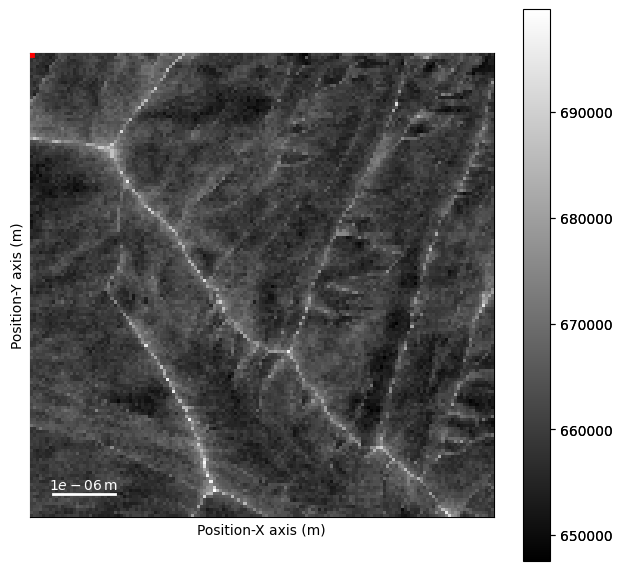

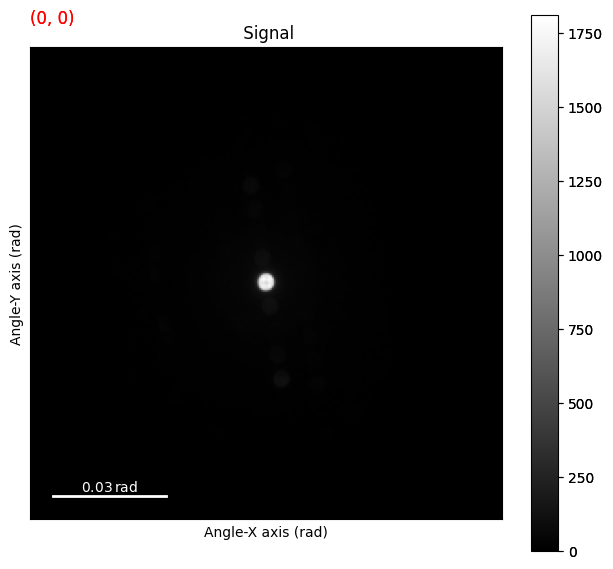

In [ ]:

sliced_data_file = data_file.inav[:150,:150]
sliced_data_file.plot(scalebar=True)
print(sliced_data_file)

# NMF segmentation

In [5]:
############################################################### using NMF in pyxem, central beam blocked 
n_components = 20
print(sliced_data_file)
sliced_data_file.change_dtype('float64')
print(sliced_data_file)

<Signal2D, title: , dimensions: (150, 150|256, 256)>
<Signal2D, title: , dimensions: (150, 150|256, 256)>


In [6]:

image_set_4d = sliced_data_file
dpm = pxm.signals.Diffraction2D(image_set_4d.inav[0,0])
signal_mask = dpm.get_direct_beam_mask(radius=15)



In [7]:

image_set_4d.decomposition(normalize_poissonian_noise=True,
                 algorithm='nmf',
                 output_dimension=n_components,
                 signal_mask=signal_mask.data,
                 verbose=True)


MemoryError: Unable to allocate 10.9 GiB for an array with shape (22500, 64820) and data type float64

## Look into changing the NMF step or adding a CNN and/or a tCNN for better predictions and upscaling

In [ ]:

dp_nmf = image_set_4d.get_decomposition_model(components=np.arange(n_components))
factors = dp_nmf.get_decomposition_factors()
loadings = dp_nmf.get_decomposition_loadings()
mapping = loadings.data


In [ ]:

############################################################### non-mixing mapping based on NMF factor
mapping_index = np.zeros([mapping_x, mapping_y])
for i in range(mapping_x):
    for j in range(mapping_y):
        mapping_index[i, j] = mapping[1:,i,j].argmax() + 1
print(mapping_index.max())
plt.figure()
plt.subplot(1,2,1)
plt.imshow(mapping_index,cmap = 'jet')


In [ ]:

############################################################## Correlate NMF Loading Maps till converge
corr_th_factors = 0.45
corr_th_loadings = 0.3

n_components_ = n_components-1
while n_components != n_components_:
    n_components = n_components_
    learn = LearningSegment(factors=factors, loadings=loadings)
    ncc_nmf = learn.get_ncc_matrix()
    # ncc_nmf.plot(scalebar=False, cmap='RdBu')
    learn_corr = learn.correlate_learning_segments(corr_th_factors=corr_th_factors,
                                                   corr_th_loadings=corr_th_loadings)
    loadings = learn_corr.loadings
    factors = learn_corr.factors
    n_components_ = loadings.data.shape[0]
    print("num of component = ", n_components_)

n_components = loadings.data.shape[0]
mapping = loadings.data.reshape([n_components, mapping_x, mapping_y])
mapping_index = np.zeros([mapping_x, mapping_y])
for i in range(mapping_x):
    for j in range(mapping_y):
        mapping_index[i, j] = mapping[:,i,j].argmax()
plt.subplot(1,2,2)
plt.imshow(mapping_index,cmap = 'jet')



In [ ]:

########################################################### plot diff patterns
diff_set = adjust_gamma(factors.data, 0.2)
cmap_jet = matplotlib.cm.get_cmap('jet')

plt.figure(figsize = (10,4))
plt.subplot(1,3,1)
plt.imshow(diff_set[0], cmap=CustomCmap([0,0,0],cmap_jet(10/50)[:3]))
plt.subplot(1,3,2)
plt.imshow(diff_set[40], cmap=CustomCmap([0,0,0],cmap_jet(16/50)[:3]))
plt.subplot(1,3,3)
plt.imshow(diff_set[25], cmap=CustomCmap([0,0,0],cmap_jet(44/50)[:3]))



In [ ]:
# save point
loadings.save("data/loadings_"+str(num_of_dataset)+".hspy")
factors.save("data/factors_"+str(num_of_dataset)+".hspy")

In [ ]:
diff = copy.deepcopy(factors.data)
for i in range(len(diff)):
    diff[i] = adjust_gamma(gaussian_filter(diff[i], 1),0.2)
plot_gallery("Non-negative components - NMF", diff[0:])